In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
from tqdm.notebook import tqdm

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_Ori2_Geo1_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 5)


  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [4]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['d', 'theta', 'h', 'phi', 'l_t']
[[-0.54532796  0.19950308  0.2467447  -0.0059728   0.78257079]
 [-0.36648332 -0.83769703 -0.33564824  0.30532084 -0.10318346]
 [ 0.59473091  0.05853246 -0.31366349  0.12593238 -0.15249521]
 ...
 [-0.26264348 -0.37940062  0.95769607  0.84008016  0.23478598]
 [-0.01424659 -0.12016722  0.92645932 -0.25468492 -0.40433452]
 [-0.1353533  -0.07019125  0.14896279 -0.97961952  0.81742647]]


In [5]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [6]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:41,  1.14s/it]

Training Loss: 97.51491982117295 Validation Loss: 31.336635656654835


  4%|▎         | 11/300 [00:12<05:18,  1.10s/it]

Training Loss: 66.76007355377078 Validation Loss: 22.57439249381423


  7%|▋         | 21/300 [00:23<05:02,  1.08s/it]

Training Loss: 61.37558655068278 Validation Loss: 21.493203340098262


 10%|█         | 31/300 [00:33<04:48,  1.07s/it]

Training Loss: 52.79863937199116 Validation Loss: 19.26828489266336


 14%|█▎        | 41/300 [00:44<04:42,  1.09s/it]

Training Loss: 37.3167141629383 Validation Loss: 15.887089736759663


 17%|█▋        | 51/300 [00:55<04:16,  1.03s/it]

Training Loss: 27.665898766368628 Validation Loss: 14.567310728132725


 20%|██        | 61/300 [01:05<03:42,  1.07it/s]

Training Loss: 24.631965443957597 Validation Loss: 14.104597836732864


 24%|██▎       | 71/300 [01:15<03:50,  1.01s/it]

Training Loss: 18.816904635867104 Validation Loss: 12.272965394891798


 27%|██▋       | 81/300 [01:25<03:31,  1.04it/s]

Training Loss: 18.022886460181326 Validation Loss: 12.259826651774347


 30%|███       | 91/300 [01:35<03:32,  1.02s/it]

Training Loss: 16.299872276373208 Validation Loss: 12.612392213195562


 34%|███▎      | 101/300 [01:45<03:22,  1.02s/it]

Training Loss: 14.748482703929767 Validation Loss: 11.80213181488216


 37%|███▋      | 111/300 [01:55<03:14,  1.03s/it]

Training Loss: 14.232361057773232 Validation Loss: 11.321952922269702


 40%|████      | 121/300 [02:05<02:58,  1.00it/s]

Training Loss: 13.158292927779257 Validation Loss: 10.974014573730528


 44%|████▎     | 131/300 [02:16<02:54,  1.03s/it]

Training Loss: 12.075962498318404 Validation Loss: 11.310851945541799


 47%|████▋     | 141/300 [02:26<02:42,  1.02s/it]

Training Loss: 10.957620942033827 Validation Loss: 11.574463717639446


 50%|█████     | 151/300 [02:36<02:34,  1.04s/it]

Training Loss: 10.001297669601627 Validation Loss: 11.508967138826847


 54%|█████▎    | 161/300 [02:46<02:21,  1.02s/it]

Training Loss: 9.632240061997436 Validation Loss: 11.442949412856251


 57%|█████▋    | 171/300 [02:57<02:07,  1.01it/s]

Training Loss: 9.748503372771665 Validation Loss: 11.757027273066342


 60%|██████    | 181/300 [03:07<02:02,  1.03s/it]

Training Loss: 8.926870411261916 Validation Loss: 11.989028711803257


 64%|██████▎   | 191/300 [03:17<01:50,  1.02s/it]

Training Loss: 8.429735503857955 Validation Loss: 11.624729435425252


 67%|██████▋   | 201/300 [03:27<01:42,  1.03s/it]

Training Loss: 8.809632671065629 Validation Loss: 11.591063842643052


 70%|███████   | 211/300 [03:38<01:32,  1.03s/it]

Training Loss: 7.7827959429705516 Validation Loss: 11.412965673021972


 74%|███████▎  | 221/300 [03:48<01:21,  1.03s/it]

Training Loss: 7.42075670347549 Validation Loss: 11.399498323909938


 77%|███████▋  | 231/300 [03:57<01:09,  1.01s/it]

Training Loss: 7.266649454482831 Validation Loss: 11.531219149008393


 80%|████████  | 241/300 [04:08<01:00,  1.02s/it]

Training Loss: 7.006154155533295 Validation Loss: 11.57471064850688


 84%|████████▎ | 251/300 [04:18<00:48,  1.01it/s]

Training Loss: 6.894122224039165 Validation Loss: 11.6355069889687


 87%|████████▋ | 261/300 [04:28<00:40,  1.03s/it]

Training Loss: 6.69218961551087 Validation Loss: 11.665785304736346


 90%|█████████ | 271/300 [04:38<00:29,  1.02s/it]

Training Loss: 6.559592580073513 Validation Loss: 11.705693751573563


 94%|█████████▎| 281/300 [04:48<00:19,  1.01s/it]

Training Loss: 6.298406479123514 Validation Loss: 11.79403969598934


 97%|█████████▋| 291/300 [04:58<00:09,  1.04s/it]

Training Loss: 6.146344563981984 Validation Loss: 11.827183730434626


100%|██████████| 300/300 [05:07<00:00,  1.03s/it]


In [7]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.5488072907567836
(128, 5)
(128, 5)


<IPython.core.display.Javascript object>


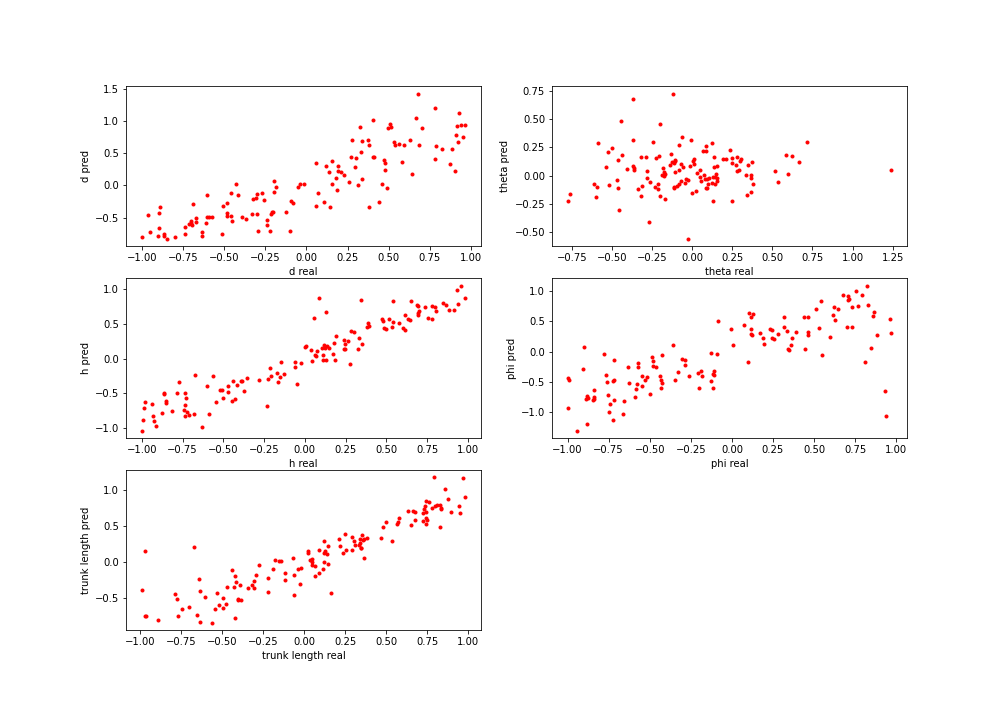

In [10]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))

ax_d = plt.subplot(321)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(322)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(323)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(324)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(325)
ax_lt.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')


plt.show()

<IPython.core.display.Javascript object>


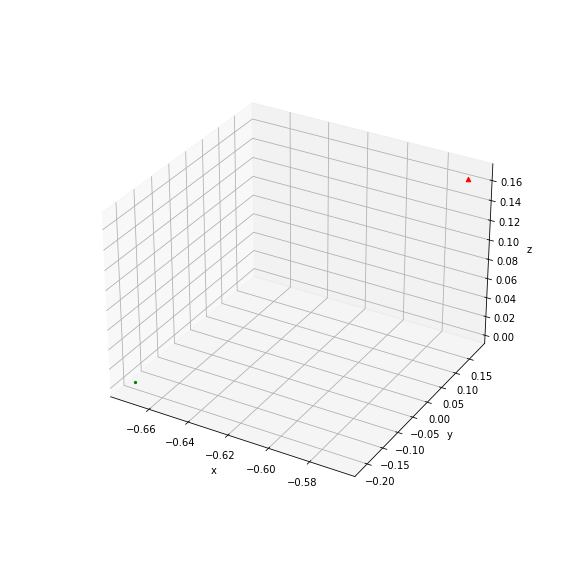

Text(0.5, 0, 'z')

In [9]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()